# Task 3.2 with ResNeXt101 64x4 DLabel2 Data Augmentation to detect the board in one go

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [20]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNeXt101_64X4D_Weights.IMAGENET1K_V1
model = models.resnext101_64x4d(weights=weights)
transforms1 = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [21]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms1
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =int(piece['category_id'])
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:45]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 6479
Number of valid images: 2192
Number of test images: 2129


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 8
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


In [8]:
def print_readable_board(labels):
    piece_dict = {
    0: "P",
    1: "R",
    2: "N",
    3: "B",
    4: "Q",
    5: "K",
    6: "p",
    7: "r",
    8: "n",
    9: "b",
    10:"q",
    11: "k",
    12: "-"
}
    for i in range(8):
        result_tmp = []
        for j in range(8):
            #print(labels[i*8+j].item())
            result_tmp.append(piece_dict[labels[i*8+j].item()])
        print(result_tmp)

['-', '-', '-', 'r', '-', '-', '-', '-']
['-', '-', 'P', '-', '-', '-', '-', '-']
['-', '-', '-', '-', 'K', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['-', 'k', '-', '-', '-', '-', 'R', '-']
['-', '-', '-', '-', 'P', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']


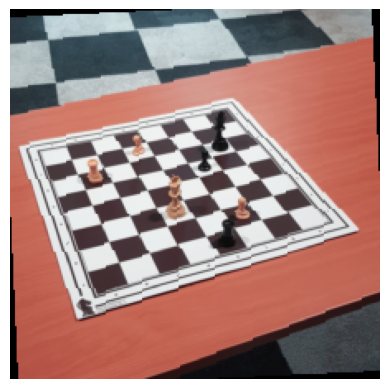

['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', '-', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']


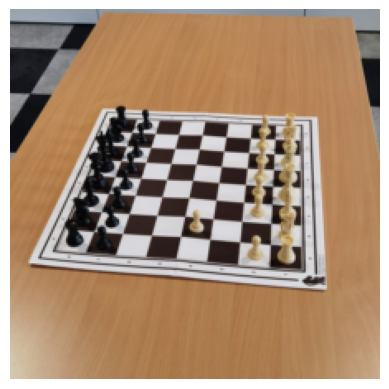

In [9]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[0].shape)
    #print(labels[0])
    print_readable_board(labels[0])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break
for batch in test_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    #print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[1])
    print_readable_board(labels[1])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[1])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [22]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, 832)
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, 64),
)
# black 
model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [11]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score,recall_score,precision_score
def calculate_metrics(all_preds, all_labels):
    # claculate the accuracy of all the board
    accuracy_list = []
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      accuracy_list.append(correct == total)
    accuracy = np.mean(accuracy_list)
    #for i in range(all_preds.shape[0]):
    all_preds = (all_preds.detach().numpy()).round().astype(int)
    all_labels = all_labels.detach().numpy().astype(int)
    #print("Test1 :",all_labels.flatten().shape, all_preds.flatten().shape)
    #print("Test1 :",all_labels.flatten(), all_preds.flatten())
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='macro',zero_division=0)
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='macro',zero_division=0)
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='macro',zero_division=0)
    recall1 = recall_score(all_labels.flatten(), all_preds.flatten(), average='micro',zero_division=0)
    precision1 = precision_score(all_labels.flatten(), all_preds.flatten(), average='micro',zero_division=0)
    f11 = f1_score(all_labels.flatten(), all_preds.flatten(), average='micro',zero_division=0)
    print(f"Micro: Recall: {recall1:.4f}, Precision: {precision1:.4f}, F1: {f11:.4f}")
    return accuracy, recall, precision, f1
def claculateMissMatchs(all_preds, all_labels):
    accuracyList = np.zeros(64, dtype=int)
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      missmatched =total- correct
      accuracyList[missmatched] += 1
    return accuracyList

## Train the model

Define function to perform one iteration

In [23]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device) # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred).view(-1, 8, 8, 13)

          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          pred_loss = scaled_pred.permute(0, 3, 1, 2)
          #print("Pred shape:",pred_loss.shape,y.view( -1,8, 8).shape)
          loss = loss_fn( pred_loss, y.view( -1,8, 8))
          #print("Scaled pred shape:",scaled_pred)
          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
          #print("Test metrics:",scaled_pred.argmax(dim=-1).view( -1, 64).shape)
          preds.append(scaled_pred.argmax(dim=-1).view( -1, 64).cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.append(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    #print("All preds shape:",all_preds.shape)
    #print("All labels shape:",all_labels.shape)
    accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy, recall, precision, f1

Define function to train a model

In [24]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  val_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  best_val_loss = np.inf
  trigger_times = 0
  best_val_loss = float('inf')
  patience = 10  # Chess models often need longer to converge
  min_delta = 0.0001  # Minimum improvement to reset patience
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc,train_recall,train_precision,train_f1 = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f} \t Train recall: {train_recall:.5f} \t Train precision: {train_precision:.5f} \t Train f1: {train_f1:.5f}")
      val_loss, val_acc,val_recall,val_precision,val_f1 = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f} \t Val recall: {val_recall:.5f} \t Val precision: {val_precision:.5f} \t Val f1: {val_f1:.5f}")


      # Early stoping
      if val_loss < (best_val_loss - min_delta):
          best_val_loss = val_loss
          trigger_times = 0
      else:
          trigger_times += 1
          if trigger_times >= patience:
              print("Early stopping!")
              break
      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)
      train_history["recall"].append(train_recall)
      train_history["precision"].append(train_precision)
      train_history["f1"].append(train_f1)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      val_history["recall"].append(val_recall)
      val_history["precision"].append(val_precision)
      val_history["f1"].append(val_f1)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [ ]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 200

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 809/809 [02:32<00:00,  5.31it/s]


Micro: Recall: 0.7377, Precision: 0.7377, F1: 0.7377
Train loss: 0.97488 	 Train acc: 0.00216 	 Train recall: 0.37886 	 Train precision: 0.65457 	 Train f1: 0.46663


100%|██████████| 274/274 [00:15<00:00, 18.23it/s]


Micro: Recall: 0.7736, Precision: 0.7736, F1: 0.7736
Val loss: 0.81091 	 Val acc: 0.00091 	 Val recall: 0.39866 	 Val precision: 0.73648 	 Val f1: 0.50178

Epoch 2


100%|██████████| 809/809 [02:44<00:00,  4.93it/s]


Micro: Recall: 0.7731, Precision: 0.7731, F1: 0.7731
Train loss: 0.74977 	 Train acc: 0.00417 	 Train recall: 0.40182 	 Train precision: 0.76462 	 Train f1: 0.50762


100%|██████████| 274/274 [00:17<00:00, 15.71it/s]


Micro: Recall: 0.7895, Precision: 0.7895, F1: 0.7895
Val loss: 0.80932 	 Val acc: 0.00639 	 Val recall: 0.46326 	 Val precision: 0.73565 	 Val f1: 0.55837

Epoch 3


100%|██████████| 809/809 [02:42<00:00,  4.98it/s]


Micro: Recall: 0.8046, Precision: 0.8046, F1: 0.8046
Train loss: 0.65206 	 Train acc: 0.00494 	 Train recall: 0.45242 	 Train precision: 0.79684 	 Train f1: 0.55913


100%|██████████| 274/274 [00:14<00:00, 19.46it/s]


Micro: Recall: 0.8178, Precision: 0.8178, F1: 0.8178
Val loss: 0.67148 	 Val acc: 0.00776 	 Val recall: 0.43154 	 Val precision: 0.87197 	 Val f1: 0.55391

Epoch 4


100%|██████████| 809/809 [02:25<00:00,  5.55it/s]


Micro: Recall: 0.8373, Precision: 0.8373, F1: 0.8373
Train loss: 0.55293 	 Train acc: 0.00834 	 Train recall: 0.50761 	 Train precision: 0.83760 	 Train f1: 0.61515


100%|██████████| 274/274 [00:14<00:00, 19.43it/s]


Micro: Recall: 0.8417, Precision: 0.8417, F1: 0.8417
Val loss: 0.60796 	 Val acc: 0.01186 	 Val recall: 0.47394 	 Val precision: 0.88168 	 Val f1: 0.59285

Epoch 5


100%|██████████| 809/809 [02:24<00:00,  5.60it/s]


Micro: Recall: 0.8624, Precision: 0.8624, F1: 0.8624
Train loss: 0.47735 	 Train acc: 0.01375 	 Train recall: 0.55535 	 Train precision: 0.86799 	 Train f1: 0.66172


100%|██████████| 274/274 [00:14<00:00, 19.34it/s]


Micro: Recall: 0.8613, Precision: 0.8613, F1: 0.8613
Val loss: 0.54851 	 Val acc: 0.03057 	 Val recall: 0.52730 	 Val precision: 0.88651 	 Val f1: 0.64461

Epoch 6


100%|██████████| 809/809 [02:24<00:00,  5.59it/s]


Micro: Recall: 0.8823, Precision: 0.8823, F1: 0.8823
Train loss: 0.41676 	 Train acc: 0.01483 	 Train recall: 0.59963 	 Train precision: 0.88803 	 Train f1: 0.70259


100%|██████████| 274/274 [00:14<00:00, 19.55it/s]


Micro: Recall: 0.8712, Precision: 0.8712, F1: 0.8712
Val loss: 0.50667 	 Val acc: 0.02600 	 Val recall: 0.53626 	 Val precision: 0.90402 	 Val f1: 0.65493

Epoch 7


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.8967, Precision: 0.8967, F1: 0.8967
Train loss: 0.37169 	 Train acc: 0.02194 	 Train recall: 0.63547 	 Train precision: 0.89979 	 Train f1: 0.73368


100%|██████████| 274/274 [00:14<00:00, 19.47it/s]


Micro: Recall: 0.8802, Precision: 0.8802, F1: 0.8802
Val loss: 0.46500 	 Val acc: 0.02783 	 Val recall: 0.55856 	 Val precision: 0.89164 	 Val f1: 0.67184

Epoch 8


100%|██████████| 809/809 [02:24<00:00,  5.60it/s]


Micro: Recall: 0.9072, Precision: 0.9072, F1: 0.9072
Train loss: 0.33667 	 Train acc: 0.02750 	 Train recall: 0.66432 	 Train precision: 0.90764 	 Train f1: 0.75745


100%|██████████| 274/274 [00:14<00:00, 19.49it/s]


Micro: Recall: 0.8893, Precision: 0.8893, F1: 0.8893
Val loss: 0.43643 	 Val acc: 0.03832 	 Val recall: 0.56765 	 Val precision: 0.89490 	 Val f1: 0.67872

Epoch 9


100%|██████████| 809/809 [02:35<00:00,  5.20it/s]


Micro: Recall: 0.9158, Precision: 0.9158, F1: 0.9158
Train loss: 0.31094 	 Train acc: 0.02781 	 Train recall: 0.69082 	 Train precision: 0.91323 	 Train f1: 0.77857


100%|██████████| 274/274 [00:13<00:00, 19.57it/s]


Micro: Recall: 0.8979, Precision: 0.8979, F1: 0.8979
Val loss: 0.40818 	 Val acc: 0.03878 	 Val recall: 0.58752 	 Val precision: 0.87802 	 Val f1: 0.69063

Epoch 10


100%|██████████| 809/809 [02:25<00:00,  5.56it/s]


Micro: Recall: 0.9215, Precision: 0.9215, F1: 0.9215
Train loss: 0.29285 	 Train acc: 0.03106 	 Train recall: 0.71031 	 Train precision: 0.91735 	 Train f1: 0.79362


100%|██████████| 274/274 [00:14<00:00, 19.09it/s]


Micro: Recall: 0.9018, Precision: 0.9018, F1: 0.9018
Val loss: 0.39029 	 Val acc: 0.04151 	 Val recall: 0.59329 	 Val precision: 0.88114 	 Val f1: 0.69608

Epoch 11


100%|██████████| 809/809 [02:25<00:00,  5.57it/s]


Micro: Recall: 0.9276, Precision: 0.9276, F1: 0.9276
Train loss: 0.27383 	 Train acc: 0.03878 	 Train recall: 0.72964 	 Train precision: 0.91891 	 Train f1: 0.80739


100%|██████████| 274/274 [00:14<00:00, 19.47it/s]


Micro: Recall: 0.9074, Precision: 0.9074, F1: 0.9074
Val loss: 0.37458 	 Val acc: 0.05566 	 Val recall: 0.61168 	 Val precision: 0.86340 	 Val f1: 0.70516

Epoch 12


100%|██████████| 809/809 [02:24<00:00,  5.59it/s]


Micro: Recall: 0.9311, Precision: 0.9311, F1: 0.9311
Train loss: 0.26439 	 Train acc: 0.03925 	 Train recall: 0.74185 	 Train precision: 0.92322 	 Train f1: 0.81726


100%|██████████| 274/274 [00:14<00:00, 19.34it/s]


Micro: Recall: 0.9123, Precision: 0.9123, F1: 0.9123
Val loss: 0.35898 	 Val acc: 0.05611 	 Val recall: 0.61931 	 Val precision: 0.85738 	 Val f1: 0.70826

Epoch 13


100%|██████████| 809/809 [02:24<00:00,  5.58it/s]


Micro: Recall: 0.9347, Precision: 0.9347, F1: 0.9347
Train loss: 0.25415 	 Train acc: 0.04620 	 Train recall: 0.75474 	 Train precision: 0.92440 	 Train f1: 0.82616


100%|██████████| 274/274 [00:14<00:00, 19.49it/s]


Micro: Recall: 0.9111, Precision: 0.9111, F1: 0.9111
Val loss: 0.34768 	 Val acc: 0.06341 	 Val recall: 0.62166 	 Val precision: 0.85085 	 Val f1: 0.70892

Epoch 14


100%|██████████| 809/809 [02:25<00:00,  5.56it/s]


Micro: Recall: 0.9381, Precision: 0.9381, F1: 0.9381
Train loss: 0.24406 	 Train acc: 0.04744 	 Train recall: 0.76623 	 Train precision: 0.92853 	 Train f1: 0.83520


100%|██████████| 274/274 [00:14<00:00, 19.48it/s]


Micro: Recall: 0.9128, Precision: 0.9128, F1: 0.9128
Val loss: 0.34644 	 Val acc: 0.06524 	 Val recall: 0.62925 	 Val precision: 0.84253 	 Val f1: 0.71233

Epoch 15


100%|██████████| 809/809 [02:24<00:00,  5.59it/s]


Micro: Recall: 0.9391, Precision: 0.9391, F1: 0.9391
Train loss: 0.24164 	 Train acc: 0.04867 	 Train recall: 0.77043 	 Train precision: 0.92806 	 Train f1: 0.83773


100%|██████████| 274/274 [00:14<00:00, 18.83it/s]


Micro: Recall: 0.9193, Precision: 0.9193, F1: 0.9193
Val loss: 0.33006 	 Val acc: 0.07026 	 Val recall: 0.64220 	 Val precision: 0.83704 	 Val f1: 0.71871

Epoch 16


100%|██████████| 809/809 [02:49<00:00,  4.77it/s]


Micro: Recall: 0.9415, Precision: 0.9415, F1: 0.9415
Train loss: 0.23445 	 Train acc: 0.05068 	 Train recall: 0.77771 	 Train precision: 0.93001 	 Train f1: 0.84317


100%|██████████| 274/274 [00:15<00:00, 17.13it/s]


Micro: Recall: 0.9170, Precision: 0.9170, F1: 0.9170
Val loss: 0.33412 	 Val acc: 0.06615 	 Val recall: 0.63631 	 Val precision: 0.85484 	 Val f1: 0.72112

Epoch 17


100%|██████████| 809/809 [03:05<00:00,  4.36it/s]


Micro: Recall: 0.9439, Precision: 0.9439, F1: 0.9439
Train loss: 0.22889 	 Train acc: 0.05315 	 Train recall: 0.78523 	 Train precision: 0.93187 	 Train f1: 0.84863


100%|██████████| 274/274 [00:15<00:00, 17.17it/s]


Micro: Recall: 0.9183, Precision: 0.9183, F1: 0.9183
Val loss: 0.33021 	 Val acc: 0.06889 	 Val recall: 0.63241 	 Val precision: 0.83576 	 Val f1: 0.71132

Epoch 18


100%|██████████| 809/809 [02:43<00:00,  4.94it/s]


Micro: Recall: 0.9450, Precision: 0.9450, F1: 0.9450
Train loss: 0.22411 	 Train acc: 0.05532 	 Train recall: 0.78950 	 Train precision: 0.93220 	 Train f1: 0.85137


100%|██████████| 274/274 [00:15<00:00, 17.59it/s]


Micro: Recall: 0.9198, Precision: 0.9198, F1: 0.9198
Val loss: 0.32532 	 Val acc: 0.06797 	 Val recall: 0.64071 	 Val precision: 0.84611 	 Val f1: 0.72113

Epoch 19


100%|██████████| 809/809 [02:29<00:00,  5.41it/s]


Micro: Recall: 0.9465, Precision: 0.9465, F1: 0.9465
Train loss: 0.22112 	 Train acc: 0.06041 	 Train recall: 0.79341 	 Train precision: 0.93566 	 Train f1: 0.85517


100%|██████████| 274/274 [00:14<00:00, 19.39it/s]


Micro: Recall: 0.9193, Precision: 0.9193, F1: 0.9193
Val loss: 0.32587 	 Val acc: 0.06432 	 Val recall: 0.64376 	 Val precision: 0.84263 	 Val f1: 0.72226

Epoch 20


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9463, Precision: 0.9463, F1: 0.9463
Train loss: 0.22149 	 Train acc: 0.06026 	 Train recall: 0.79410 	 Train precision: 0.93424 	 Train f1: 0.85495


100%|██████████| 274/274 [00:14<00:00, 19.53it/s]


Micro: Recall: 0.9262, Precision: 0.9262, F1: 0.9262
Val loss: 0.30542 	 Val acc: 0.07254 	 Val recall: 0.65745 	 Val precision: 0.83350 	 Val f1: 0.72802

Epoch 21


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9476, Precision: 0.9476, F1: 0.9476
Train loss: 0.21796 	 Train acc: 0.06938 	 Train recall: 0.79909 	 Train precision: 0.93485 	 Train f1: 0.85841


100%|██████████| 274/274 [00:14<00:00, 19.48it/s]


Micro: Recall: 0.9160, Precision: 0.9160, F1: 0.9160
Val loss: 0.33763 	 Val acc: 0.06615 	 Val recall: 0.63791 	 Val precision: 0.82362 	 Val f1: 0.71201

Epoch 22


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9495, Precision: 0.9495, F1: 0.9495
Train loss: 0.21306 	 Train acc: 0.06644 	 Train recall: 0.80425 	 Train precision: 0.93727 	 Train f1: 0.86248


100%|██████████| 274/274 [00:14<00:00, 19.54it/s]


Micro: Recall: 0.9244, Precision: 0.9244, F1: 0.9244
Val loss: 0.30740 	 Val acc: 0.07664 	 Val recall: 0.65195 	 Val precision: 0.82895 	 Val f1: 0.72328

Epoch 23


100%|██████████| 809/809 [02:23<00:00,  5.62it/s]


Micro: Recall: 0.9498, Precision: 0.9498, F1: 0.9498
Train loss: 0.21258 	 Train acc: 0.07231 	 Train recall: 0.80593 	 Train precision: 0.93919 	 Train f1: 0.86441


100%|██████████| 274/274 [00:14<00:00, 19.44it/s]


Micro: Recall: 0.9265, Precision: 0.9265, F1: 0.9265
Val loss: 0.30627 	 Val acc: 0.07573 	 Val recall: 0.66002 	 Val precision: 0.83310 	 Val f1: 0.72959

Epoch 24


100%|██████████| 809/809 [02:23<00:00,  5.62it/s]


Micro: Recall: 0.9485, Precision: 0.9485, F1: 0.9485
Train loss: 0.21604 	 Train acc: 0.06551 	 Train recall: 0.80234 	 Train precision: 0.93535 	 Train f1: 0.86063


100%|██████████| 274/274 [00:14<00:00, 19.56it/s]


Micro: Recall: 0.9268, Precision: 0.9268, F1: 0.9268
Val loss: 0.30266 	 Val acc: 0.07892 	 Val recall: 0.66066 	 Val precision: 0.83027 	 Val f1: 0.72911

Epoch 25


100%|██████████| 809/809 [02:23<00:00,  5.63it/s]


Micro: Recall: 0.9516, Precision: 0.9516, F1: 0.9516
Train loss: 0.20795 	 Train acc: 0.07447 	 Train recall: 0.81062 	 Train precision: 0.94088 	 Train f1: 0.86781


100%|██████████| 274/274 [00:14<00:00, 19.51it/s]


Micro: Recall: 0.9271, Precision: 0.9271, F1: 0.9271
Val loss: 0.29898 	 Val acc: 0.07892 	 Val recall: 0.65983 	 Val precision: 0.83219 	 Val f1: 0.72944

Epoch 26


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9519, Precision: 0.9519, F1: 0.9519
Train loss: 0.20760 	 Train acc: 0.07339 	 Train recall: 0.81248 	 Train precision: 0.93954 	 Train f1: 0.86858


100%|██████████| 274/274 [00:13<00:00, 19.60it/s]


Micro: Recall: 0.9249, Precision: 0.9249, F1: 0.9249
Val loss: 0.30511 	 Val acc: 0.07801 	 Val recall: 0.65625 	 Val precision: 0.83418 	 Val f1: 0.72784

Epoch 27


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9521, Precision: 0.9521, F1: 0.9521
Train loss: 0.20706 	 Train acc: 0.07525 	 Train recall: 0.81430 	 Train precision: 0.93964 	 Train f1: 0.86961


100%|██████████| 274/274 [00:13<00:00, 19.58it/s]


Micro: Recall: 0.9225, Precision: 0.9225, F1: 0.9225
Val loss: 0.30813 	 Val acc: 0.06934 	 Val recall: 0.65085 	 Val precision: 0.84897 	 Val f1: 0.72944

Epoch 28


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9513, Precision: 0.9513, F1: 0.9513
Train loss: 0.20838 	 Train acc: 0.07185 	 Train recall: 0.81123 	 Train precision: 0.94049 	 Train f1: 0.86824


100%|██████████| 274/274 [00:13<00:00, 19.58it/s]


Micro: Recall: 0.9225, Precision: 0.9225, F1: 0.9225
Val loss: 0.31401 	 Val acc: 0.07208 	 Val recall: 0.64830 	 Val precision: 0.84831 	 Val f1: 0.72734

Epoch 29


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9526, Precision: 0.9526, F1: 0.9526
Train loss: 0.20590 	 Train acc: 0.07973 	 Train recall: 0.81538 	 Train precision: 0.94215 	 Train f1: 0.87130


100%|██████████| 274/274 [00:14<00:00, 19.57it/s]


Micro: Recall: 0.9264, Precision: 0.9264, F1: 0.9264
Val loss: 0.29910 	 Val acc: 0.07892 	 Val recall: 0.65671 	 Val precision: 0.83471 	 Val f1: 0.72824

Epoch 30


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9521, Precision: 0.9521, F1: 0.9521
Train loss: 0.20730 	 Train acc: 0.07540 	 Train recall: 0.81530 	 Train precision: 0.93950 	 Train f1: 0.87032


100%|██████████| 274/274 [00:14<00:00, 19.53it/s]


Micro: Recall: 0.9264, Precision: 0.9264, F1: 0.9264
Val loss: 0.30346 	 Val acc: 0.07755 	 Val recall: 0.66187 	 Val precision: 0.84031 	 Val f1: 0.73373

Epoch 31


100%|██████████| 809/809 [02:23<00:00,  5.62it/s]


Micro: Recall: 0.9538, Precision: 0.9538, F1: 0.9538
Train loss: 0.20324 	 Train acc: 0.08066 	 Train recall: 0.81834 	 Train precision: 0.94290 	 Train f1: 0.87339


100%|██████████| 274/274 [00:13<00:00, 19.62it/s]


Micro: Recall: 0.9274, Precision: 0.9274, F1: 0.9274
Val loss: 0.29783 	 Val acc: 0.07801 	 Val recall: 0.66170 	 Val precision: 0.83390 	 Val f1: 0.73139

Epoch 32


100%|██████████| 809/809 [02:23<00:00,  5.62it/s]


Micro: Recall: 0.9538, Precision: 0.9538, F1: 0.9538
Train loss: 0.20314 	 Train acc: 0.08050 	 Train recall: 0.81999 	 Train precision: 0.94234 	 Train f1: 0.87429


100%|██████████| 274/274 [00:13<00:00, 19.59it/s]


Micro: Recall: 0.9273, Precision: 0.9273, F1: 0.9273
Val loss: 0.29879 	 Val acc: 0.07710 	 Val recall: 0.66239 	 Val precision: 0.82700 	 Val f1: 0.72907

Epoch 33


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9532, Precision: 0.9532, F1: 0.9532
Train loss: 0.20469 	 Train acc: 0.08035 	 Train recall: 0.81799 	 Train precision: 0.94275 	 Train f1: 0.87314


100%|██████████| 274/274 [00:14<00:00, 19.56it/s]


Micro: Recall: 0.9277, Precision: 0.9277, F1: 0.9277
Val loss: 0.29762 	 Val acc: 0.08120 	 Val recall: 0.66167 	 Val precision: 0.84069 	 Val f1: 0.73343

Epoch 34


100%|██████████| 809/809 [02:23<00:00,  5.63it/s]


Micro: Recall: 0.9538, Precision: 0.9538, F1: 0.9538
Train loss: 0.20294 	 Train acc: 0.07865 	 Train recall: 0.81822 	 Train precision: 0.94187 	 Train f1: 0.87287


100%|██████████| 274/274 [00:13<00:00, 19.58it/s]


Micro: Recall: 0.9284, Precision: 0.9284, F1: 0.9284
Val loss: 0.29066 	 Val acc: 0.07892 	 Val recall: 0.66552 	 Val precision: 0.83301 	 Val f1: 0.73389

Epoch 35


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9547, Precision: 0.9547, F1: 0.9547
Train loss: 0.20098 	 Train acc: 0.08019 	 Train recall: 0.82060 	 Train precision: 0.94310 	 Train f1: 0.87488


100%|██████████| 274/274 [00:13<00:00, 19.59it/s]


Micro: Recall: 0.9257, Precision: 0.9257, F1: 0.9257
Val loss: 0.29736 	 Val acc: 0.07573 	 Val recall: 0.65682 	 Val precision: 0.83847 	 Val f1: 0.72977

Epoch 36


100%|██████████| 809/809 [02:23<00:00,  5.62it/s]


Micro: Recall: 0.9548, Precision: 0.9548, F1: 0.9548
Train loss: 0.20125 	 Train acc: 0.08745 	 Train recall: 0.82249 	 Train precision: 0.94354 	 Train f1: 0.87620


100%|██████████| 274/274 [00:14<00:00, 19.43it/s]


Micro: Recall: 0.9298, Precision: 0.9298, F1: 0.9298
Val loss: 0.29028 	 Val acc: 0.08257 	 Val recall: 0.67435 	 Val precision: 0.82035 	 Val f1: 0.73529

Epoch 37


100%|██████████| 809/809 [02:23<00:00,  5.63it/s]


Micro: Recall: 0.9525, Precision: 0.9525, F1: 0.9525
Train loss: 0.20527 	 Train acc: 0.07617 	 Train recall: 0.81546 	 Train precision: 0.94114 	 Train f1: 0.87103


100%|██████████| 274/274 [00:14<00:00, 19.56it/s]


Micro: Recall: 0.9206, Precision: 0.9206, F1: 0.9206
Val loss: 0.31621 	 Val acc: 0.06934 	 Val recall: 0.64227 	 Val precision: 0.83530 	 Val f1: 0.71850

Epoch 38


100%|██████████| 809/809 [02:23<00:00,  5.62it/s]


Micro: Recall: 0.9545, Precision: 0.9545, F1: 0.9545
Train loss: 0.20095 	 Train acc: 0.08112 	 Train recall: 0.82129 	 Train precision: 0.94309 	 Train f1: 0.87536


100%|██████████| 274/274 [00:14<00:00, 19.43it/s]


Micro: Recall: 0.9274, Precision: 0.9274, F1: 0.9274
Val loss: 0.29036 	 Val acc: 0.07573 	 Val recall: 0.66197 	 Val precision: 0.83533 	 Val f1: 0.73230

Epoch 39


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9550, Precision: 0.9550, F1: 0.9550
Train loss: 0.20154 	 Train acc: 0.08637 	 Train recall: 0.82377 	 Train precision: 0.94349 	 Train f1: 0.87702


100%|██████████| 274/274 [00:13<00:00, 19.63it/s]


Micro: Recall: 0.9217, Precision: 0.9217, F1: 0.9217
Val loss: 0.31847 	 Val acc: 0.06524 	 Val recall: 0.65825 	 Val precision: 0.81957 	 Val f1: 0.72394

Epoch 40


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9544, Precision: 0.9544, F1: 0.9544
Train loss: 0.20125 	 Train acc: 0.08560 	 Train recall: 0.82041 	 Train precision: 0.94435 	 Train f1: 0.87531


100%|██████████| 274/274 [00:14<00:00, 19.42it/s]


Micro: Recall: 0.9297, Precision: 0.9297, F1: 0.9297
Val loss: 0.28685 	 Val acc: 0.08531 	 Val recall: 0.67006 	 Val precision: 0.82689 	 Val f1: 0.73459

Epoch 41


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9561, Precision: 0.9561, F1: 0.9561
Train loss: 0.19753 	 Train acc: 0.08622 	 Train recall: 0.82531 	 Train precision: 0.94616 	 Train f1: 0.87898


100%|██████████| 274/274 [00:14<00:00, 19.54it/s]


Micro: Recall: 0.9276, Precision: 0.9276, F1: 0.9276
Val loss: 0.30088 	 Val acc: 0.07619 	 Val recall: 0.66492 	 Val precision: 0.82234 	 Val f1: 0.72916

Epoch 42


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9567, Precision: 0.9567, F1: 0.9567
Train loss: 0.19645 	 Train acc: 0.08467 	 Train recall: 0.82906 	 Train precision: 0.94712 	 Train f1: 0.88168


100%|██████████| 274/274 [00:14<00:00, 19.43it/s]


Micro: Recall: 0.9287, Precision: 0.9287, F1: 0.9287
Val loss: 0.29163 	 Val acc: 0.07938 	 Val recall: 0.66545 	 Val precision: 0.82585 	 Val f1: 0.73139

Epoch 43


100%|██████████| 809/809 [02:23<00:00,  5.62it/s]


Micro: Recall: 0.9560, Precision: 0.9560, F1: 0.9560
Train loss: 0.19801 	 Train acc: 0.09178 	 Train recall: 0.82614 	 Train precision: 0.94515 	 Train f1: 0.87905


100%|██████████| 274/274 [00:13<00:00, 19.59it/s]


Micro: Recall: 0.9273, Precision: 0.9273, F1: 0.9273
Val loss: 0.29375 	 Val acc: 0.07801 	 Val recall: 0.66176 	 Val precision: 0.83427 	 Val f1: 0.73152

Epoch 44


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9543, Precision: 0.9543, F1: 0.9543
Train loss: 0.20285 	 Train acc: 0.08344 	 Train recall: 0.82120 	 Train precision: 0.94326 	 Train f1: 0.87543


100%|██████████| 274/274 [00:14<00:00, 19.57it/s]


Micro: Recall: 0.9301, Precision: 0.9301, F1: 0.9301
Val loss: 0.28403 	 Val acc: 0.08075 	 Val recall: 0.67312 	 Val precision: 0.82729 	 Val f1: 0.73670

Epoch 45


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9569, Precision: 0.9569, F1: 0.9569
Train loss: 0.19621 	 Train acc: 0.09533 	 Train recall: 0.82842 	 Train precision: 0.94646 	 Train f1: 0.88104


100%|██████████| 274/274 [00:13<00:00, 19.60it/s]


Micro: Recall: 0.9303, Precision: 0.9303, F1: 0.9303
Val loss: 0.28954 	 Val acc: 0.08440 	 Val recall: 0.67301 	 Val precision: 0.81951 	 Val f1: 0.73360

Epoch 46


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9551, Precision: 0.9551, F1: 0.9551
Train loss: 0.20024 	 Train acc: 0.08081 	 Train recall: 0.82254 	 Train precision: 0.94469 	 Train f1: 0.87672


100%|██████████| 274/274 [00:14<00:00, 19.56it/s]


Micro: Recall: 0.9304, Precision: 0.9304, F1: 0.9304
Val loss: 0.28538 	 Val acc: 0.08075 	 Val recall: 0.67158 	 Val precision: 0.83175 	 Val f1: 0.73729

Epoch 47


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9556, Precision: 0.9556, F1: 0.9556
Train loss: 0.19989 	 Train acc: 0.08452 	 Train recall: 0.82424 	 Train precision: 0.94496 	 Train f1: 0.87788


100%|██████████| 274/274 [00:13<00:00, 19.60it/s]


Micro: Recall: 0.9302, Precision: 0.9302, F1: 0.9302
Val loss: 0.28783 	 Val acc: 0.07847 	 Val recall: 0.67646 	 Val precision: 0.80801 	 Val f1: 0.73149

Epoch 48


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9562, Precision: 0.9562, F1: 0.9562
Train loss: 0.19810 	 Train acc: 0.08483 	 Train recall: 0.82495 	 Train precision: 0.94596 	 Train f1: 0.87869


100%|██████████| 274/274 [00:14<00:00, 19.56it/s]


Micro: Recall: 0.9222, Precision: 0.9222, F1: 0.9222
Val loss: 0.31026 	 Val acc: 0.07391 	 Val recall: 0.66544 	 Val precision: 0.81851 	 Val f1: 0.72871

Epoch 49


100%|██████████| 809/809 [02:23<00:00,  5.63it/s]


Micro: Recall: 0.9576, Precision: 0.9576, F1: 0.9576
Train loss: 0.19507 	 Train acc: 0.09302 	 Train recall: 0.82953 	 Train precision: 0.94818 	 Train f1: 0.88236


100%|██████████| 274/274 [00:13<00:00, 19.60it/s]


Micro: Recall: 0.9321, Precision: 0.9321, F1: 0.9321
Val loss: 0.28241 	 Val acc: 0.08394 	 Val recall: 0.67982 	 Val precision: 0.81645 	 Val f1: 0.73726

Epoch 50


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9558, Precision: 0.9558, F1: 0.9558
Train loss: 0.19819 	 Train acc: 0.08807 	 Train recall: 0.82543 	 Train precision: 0.94538 	 Train f1: 0.87872


100%|██████████| 274/274 [00:13<00:00, 19.59it/s]


Micro: Recall: 0.9262, Precision: 0.9262, F1: 0.9262
Val loss: 0.29954 	 Val acc: 0.07710 	 Val recall: 0.65445 	 Val precision: 0.83931 	 Val f1: 0.72785

Epoch 51


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9558, Precision: 0.9558, F1: 0.9558
Train loss: 0.19819 	 Train acc: 0.09271 	 Train recall: 0.82548 	 Train precision: 0.94492 	 Train f1: 0.87867


100%|██████████| 274/274 [00:14<00:00, 19.56it/s]


Micro: Recall: 0.9295, Precision: 0.9295, F1: 0.9295
Val loss: 0.29682 	 Val acc: 0.08120 	 Val recall: 0.67033 	 Val precision: 0.82653 	 Val f1: 0.73430

Epoch 52


100%|██████████| 809/809 [02:24<00:00,  5.61it/s]


Micro: Recall: 0.9559, Precision: 0.9559, F1: 0.9559
Train loss: 0.19810 	 Train acc: 0.08854 	 Train recall: 0.82520 	 Train precision: 0.94648 	 Train f1: 0.87904


100%|██████████| 274/274 [00:13<00:00, 19.58it/s]


Micro: Recall: 0.9285, Precision: 0.9285, F1: 0.9285
Val loss: 0.28869 	 Val acc: 0.08440 	 Val recall: 0.66623 	 Val precision: 0.83185 	 Val f1: 0.73368

Epoch 53


100%|██████████| 809/809 [02:23<00:00,  5.63it/s]


Micro: Recall: 0.9573, Precision: 0.9573, F1: 0.9573
Train loss: 0.19574 	 Train acc: 0.08714 	 Train recall: 0.82992 	 Train precision: 0.94730 	 Train f1: 0.88232


100%|██████████| 274/274 [00:14<00:00, 19.47it/s]


Micro: Recall: 0.9274, Precision: 0.9274, F1: 0.9274
Val loss: 0.29403 	 Val acc: 0.07755 	 Val recall: 0.66016 	 Val precision: 0.85547 	 Val f1: 0.73781

Epoch 54


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9566, Precision: 0.9566, F1: 0.9566
Train loss: 0.19743 	 Train acc: 0.09132 	 Train recall: 0.82863 	 Train precision: 0.94650 	 Train f1: 0.88117


100%|██████████| 274/274 [00:13<00:00, 19.59it/s]


Micro: Recall: 0.9263, Precision: 0.9263, F1: 0.9263
Val loss: 0.29493 	 Val acc: 0.07938 	 Val recall: 0.66590 	 Val precision: 0.82739 	 Val f1: 0.73229

Epoch 55


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9569, Precision: 0.9569, F1: 0.9569
Train loss: 0.19600 	 Train acc: 0.09394 	 Train recall: 0.82897 	 Train precision: 0.94550 	 Train f1: 0.88092


100%|██████████| 274/274 [00:14<00:00, 19.39it/s]


Micro: Recall: 0.9293, Precision: 0.9293, F1: 0.9293
Val loss: 0.28953 	 Val acc: 0.08029 	 Val recall: 0.66821 	 Val precision: 0.83430 	 Val f1: 0.73592

Epoch 56


100%|██████████| 809/809 [02:24<00:00,  5.62it/s]


Micro: Recall: 0.9557, Precision: 0.9557, F1: 0.9557
Train loss: 0.19847 	 Train acc: 0.08622 	 Train recall: 0.82439 	 Train precision: 0.94565 	 Train f1: 0.87832


100%|██████████| 274/274 [00:14<00:00, 19.56it/s]


Micro: Recall: 0.9302, Precision: 0.9302, F1: 0.9302
Val loss: 0.28907 	 Val acc: 0.08212 	 Val recall: 0.67021 	 Val precision: 0.83281 	 Val f1: 0.73670

Epoch 57


100%|██████████| 809/809 [02:23<00:00,  5.63it/s]


Micro: Recall: 0.9571, Precision: 0.9571, F1: 0.9571
Train loss: 0.19618 	 Train acc: 0.09657 	 Train recall: 0.82948 	 Train precision: 0.94814 	 Train f1: 0.88236


100%|██████████| 274/274 [00:14<00:00, 19.41it/s]


Micro: Recall: 0.9299, Precision: 0.9299, F1: 0.9299
Val loss: 0.28768 	 Val acc: 0.08075 	 Val recall: 0.67190 	 Val precision: 0.83814 	 Val f1: 0.73959

Epoch 58


100%|██████████| 809/809 [02:23<00:00,  5.63it/s]


Micro: Recall: 0.9580, Precision: 0.9580, F1: 0.9580
Train loss: 0.19313 	 Train acc: 0.09379 	 Train recall: 0.83133 	 Train precision: 0.94852 	 Train f1: 0.88364


100%|██████████| 274/274 [00:14<00:00, 19.56it/s]


Micro: Recall: 0.9311, Precision: 0.9311, F1: 0.9311
Val loss: 0.28561 	 Val acc: 0.08075 	 Val recall: 0.67142 	 Val precision: 0.82714 	 Val f1: 0.73487

Epoch 59


100%|██████████| 809/809 [02:23<00:00,  5.62it/s]


Micro: Recall: 0.9578, Precision: 0.9578, F1: 0.9578
Train loss: 0.19373 	 Train acc: 0.10167 	 Train recall: 0.83132 	 Train precision: 0.94888 	 Train f1: 0.88374


100%|██████████| 274/274 [00:14<00:00, 19.42it/s]


Micro: Recall: 0.9304, Precision: 0.9304, F1: 0.9304
Val loss: 0.28288 	 Val acc: 0.08257 	 Val recall: 0.67715 	 Val precision: 0.81378 	 Val f1: 0.73486
Early stopping!
Finished


: 

## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [15]:
def plotTrainingHistory(train_history, val_history):
    plt.figure(figsize=(15, 20))
    plt.subplot(5, 3, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(5, 3, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.subplot(5, 3, 3)
    plt.title('Classification Recall')
    plt.plot(train_history['recall'], label='train')
    plt.plot(val_history['recall'], label='val')

    plt.subplot(5, 3, 4)
    plt.title('Classification Precision')
    plt.plot(train_history['precision'], label='train')
    plt.plot(val_history['precision'], label='val')

    plt.subplot(5, 3, 5)
    plt.title('Classification F1 Score')
    plt.plot(train_history['f1'], label='train')
    plt.plot(val_history['f1'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

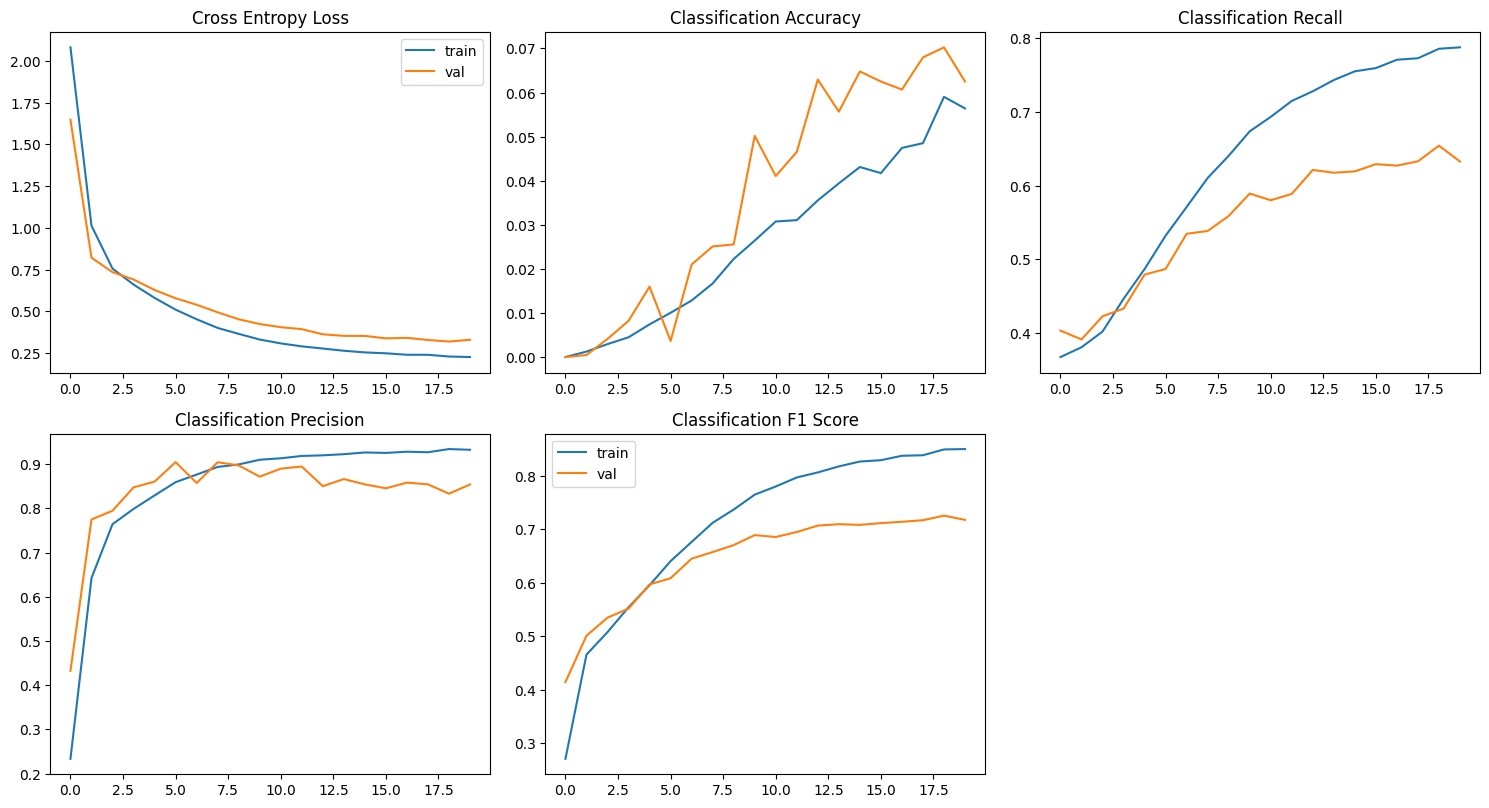

In [16]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [17]:
def plot_histogram(arr):
    max_histogram_missmatchs = 20
    arr_filtered = arr[:max_histogram_missmatchs]
    overMaxMissmachs = arr[max_histogram_missmatchs:]
    print("Filtered array:", arr_filtered)
    # Sum the values > max_histogram_missmatchs (if any exist)
    sum_over_16 = overMaxMissmachs.sum() if len(overMaxMissmachs) > 0 else 0

    # Create a new array for plotting (values ≤ 16 + one "16+" bin)
    new_arr = np.append(arr_filtered, sum_over_16)
    indices = np.arange(len(arr_filtered))
    indices = np.append(indices, str(max_histogram_missmatchs)+"+" )  # Add an index for the "16+" bin
    plt.figure(figsize=(8, 6))  # Wider graph (12 inches width, 6 height)
    # Plot the histogram (bar chart)
    plt.bar(indices, new_arr)

    # Add the numbers on top of each bar
    for i, value in enumerate(new_arr):
        if i == len(arr_filtered):
            plt.text(i, value + 0.1, f'{value}', ha='center', va='bottom')
        plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

    # Customize the plot
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Histogram of Array Values')
    plt.xticks(indices)  # Ensure all indices are shown

    # Display the plot
    plt.show()

100%|██████████| 267/267 [00:17<00:00, 15.26it/s]


All preds shape: torch.Size([2129, 64])
All preds shape: tensor([[ 1,  2,  3,  ...,  9,  8,  7],
        [ 1,  2,  3,  ...,  9,  8,  7],
        [ 1,  2,  3,  ...,  9,  8,  7],
        ...,
        [12, 12, 12,  ..., 12, 12, 12],
        [12, 12, 12,  ..., 12, 12, 12],
        [12, 12, 12,  ..., 12, 12, 12]])
Micro: Recall: 0.9135, Precision: 0.9135, F1: 0.9135
Missing pieces per board: [152  82  73 175 234 305 316 290 209 119  85  41  27  13   5   3   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Filtered array: [152  82  73 175 234 305 316 290 209 119  85  41  27  13   5   3   0   0
   0   0]


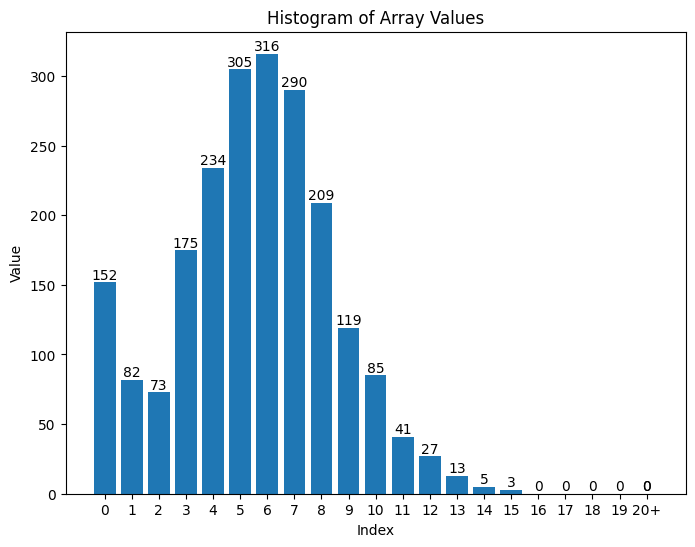

Test accuracy: 0.071, Test recall: 0.645, Test precision: 0.845, Test f1: 0.724


In [18]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
#model.load_state_dict(torch.load('chess_model_best_model.pth')['model'])
def test(dataloader):
    preds = []
    labels = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            #print("Pred shape:", pred.shape)
            predsTmp = pred.view(-1, 64, 13)
            preds.append(predsTmp.argmax(dim=-1).cpu())
            #print(predsTmp.argmax(dim=-1).cpu())
            #print(preds)
            #print(final_pred.cpu().numpy())
            #original_values =y.cpu().argmax(dim=-1) + 1
            labels.append(y.cpu())
        #print(labels.shape,preds.shape)
        all_preds = torch.cat(preds)
        all_labels = torch.cat(labels)
        print("All preds shape:", all_preds.shape)
        print("All preds shape:", all_preds)
        #print("All preds shape:",all_preds.shape,"All labels shape:",all_labels.shape)
        accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
        missing_list = claculateMissMatchs(all_preds, all_labels)
        print("Missing pieces per board:", missing_list)
        plot_histogram(missing_list)
        return accuracy, recall, precision, f1
accuracy, recall, precision, f1 = test(test_dataloader)
print(f"Test accuracy: {accuracy:.3f}, Test recall: {recall:.3f}, Test precision: {precision:.3f}, Test f1: {f1:.3f}")

  0%|          | 0/267 [00:00<?, ?it/s]

Predictions:


['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']


Ground Truth:


['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']
Micro: Recall: 0.9785, Precision: 0.9785, F1: 0.9785
Accuracy: 0.375, Recall: 0.969, Precision: 0.992, F1: 0.978


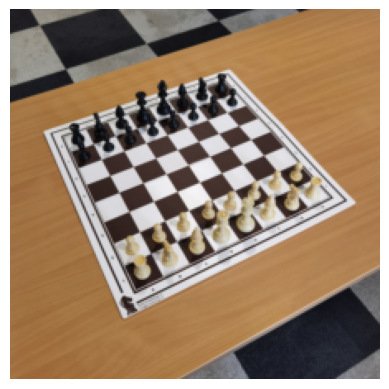

  0%|          | 1/267 [00:00<00:40,  6.49it/s]

Predictions:


['R', '-', 'B', 'K', 'Q', '-', 'N', 'R']
['P', 'P', 'P', '-', '-', 'P', 'P', 'P']
['-', '-', 'N', 'P', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['-', '-', 'n', 'p', '-', '-', '-', '-']
['p', 'p', 'p', '-', '-', 'p', 'p', 'p']
['r', '-', 'b', 'k', 'q', '-', 'n', 'r']


Ground Truth:


['R', '-', 'B', 'K', 'Q', '-', 'N', 'R']
['P', 'P', 'P', '-', 'P', 'P', 'B', 'P']
['-', '-', 'N', 'P', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['-', '-', 'n', 'p', '-', '-', '-', '-']
['p', 'p', 'p', '-', '-', 'p', 'p', 'p']
['r', '-', 'b', 'k', 'q', '-', 'n', 'r']
Micro: Recall: 0.9336, Precision: 0.9336, F1: 0.9336
Accuracy: 0.000, Recall: 0.884, Precision: 0.949, F1: 0.907


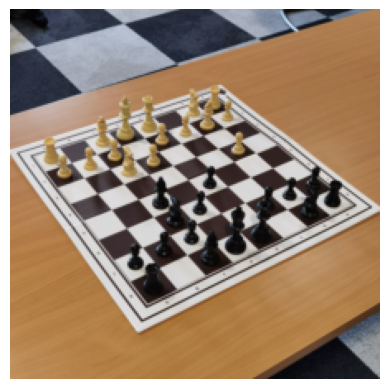

  1%|          | 2/267 [00:00<00:41,  6.42it/s]

Predictions:


['R', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'N', '-', 'P', '-']
['-', '-', 'N', '-', '-', 'P', '-', 'P']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'n', '-', '-']
['-', 'p', '-', '-', '-', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']


Ground Truth:


['R', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'P', '-', 'B', '-']
['-', '-', 'N', 'P', '-', 'N', '-', 'P']
['-', '-', '-', '-', '-', 'P', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'p', '-', '-']
['-', 'p', 'p', '-', 'n', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']
Micro: Recall: 0.9238, Precision: 0.9238, F1: 0.9238
Accuracy: 0.000, Recall: 0.860, Precision: 0.928, F1: 0.881


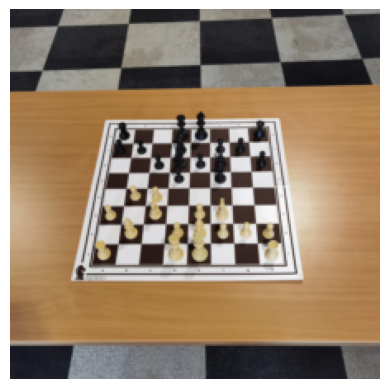

  1%|          | 3/267 [00:00<00:39,  6.61it/s]

Predictions:


['-', 'K', 'R', '-', 'Q', '-', '-', 'R']
['-', 'P', 'P', '-', '-', '-', 'P', '-']
['-', '-', '-', 'P', 'B', 'N', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', '-', 'n', '-', 'p', 'n', '-', 'p']
['-', 'p', 'p', '-', 'n', '-', 'p', '-']
['-', 'k', 'r', '-', 'q', '-', '-', 'r']


Ground Truth:


['-', 'K', 'R', '-', 'Q', '-', '-', 'R']
['P', 'P', 'P', '-', '-', '-', 'B', '-']
['-', '-', 'N', 'P', 'b', 'N', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'P', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'p', '-', 'p']
['-', 'p', 'p', 'q', 'n', '-', 'p', '-']
['-', 'k', 'r', '-', '-', '-', '-', 'r']
Micro: Recall: 0.9082, Precision: 0.9082, F1: 0.9082
Accuracy: 0.000, Recall: 0.701, Precision: 0.758, F1: 0.701


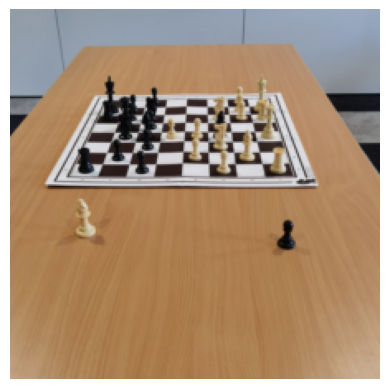

  1%|▏         | 4/267 [00:00<00:38,  6.76it/s]

Predictions:


['-', '-', '-', 'R', '-', '-', '-', 'R']
['-', 'B', 'P', '-', 'N', '-', '-', '-']
['-', 'P', '-', '-', 'B', 'N', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['-', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', '-', 'q', '-', 'p', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']


Ground Truth:


['-', '-', '-', 'R', '-', '-', '-', 'R']
['K', 'P', 'P', '-', 'N', '-', 'B', '-']
['-', '-', '-', 'P', 'Q', 'N', '-', 'P']
['-', 'n', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', 'q', 'n', '-', 'p', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Micro: Recall: 0.8809, Precision: 0.8809, F1: 0.8809
Accuracy: 0.000, Recall: 0.489, Precision: 0.515, F1: 0.498


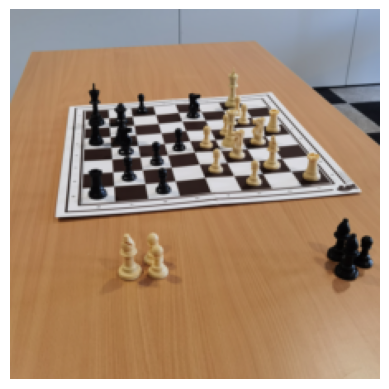

  2%|▏         | 5/267 [00:00<00:38,  6.79it/s]

Predictions:


['-', '-', '-', 'R', '-', '-', '-', 'R']
['-', 'P', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', 'P', 'B', '-', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', 'P']
['-', 'p', '-', '-', 'p', '-', 'p', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', '-', 'q', '-', '-', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']


Ground Truth:


['-', '-', '-', 'R', '-', '-', '-', 'R']
['-', 'P', '-', '-', 'N', '-', 'B', '-']
['-', 'K', '-', 'P', 'n', '-', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', 'N']
['-', 'P', '-', '-', 'p', '-', 'p', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', '-', 'n', '-', '-', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Micro: Recall: 0.9297, Precision: 0.9297, F1: 0.9297
Accuracy: 0.000, Recall: 0.610, Precision: 0.608, F1: 0.608


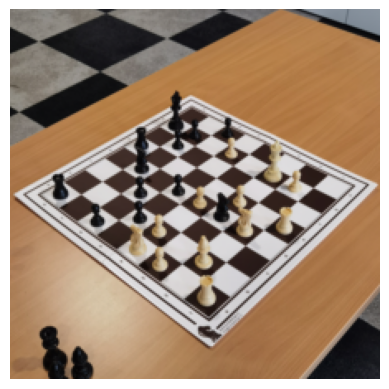

  2%|▏         | 5/267 [00:00<00:46,  5.59it/s]


In [19]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    results = 5
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = pred.view(-1, 64, 13).argmax(dim=-1).cpu()
            print("Predictions:\n\n")
            print_readable_board(predsTmp[0])
            print("\n\nGround Truth:\n\n")
            print_readable_board(y.cpu()[0])
            #print(pred.cpu().shape, y.cpu().shape)
            #print(pred1)
            accuracy, recall, precision, f1 = calculate_metrics(predsTmp, y.cpu())
            print(f"Accuracy: {accuracy:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")
            #print(pred.cpu())
            #print(y.cpu())
            imgs = X.cpu()
            imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
            plt.imshow(imgs[0])
            plt.axis('off')
            plt.show()
            results -= 1
            if results <0:
                break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?